In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from joblib import Parallel, delayed

from time import time

import plotly

import optuna
from optuna.visualization import plot_param_importances, plot_contour,  plot_slice, plot_optimization_history

In [2]:
dataset_path = 'C:/Eugenio/Maestria/DMEyF/datasets/'
dataset_file = 'competencia_01_fe.csv'

modelos_path = 'C:/Eugenio/Maestria/DMEyF/modelos/' # para guardar los modelos y no tener que volver a correrlos
db_path = 'C:/Eugenio/Maestria/DMEyF/db/'

semillas = [122219, 109279, 400391, 401537, 999961]

data = pd.read_csv(dataset_path+dataset_file)

In [3]:
ganancia_acierto = 273000
costo_estimulo = 7000

def ganancia(model, X, y, prop=1, threshold=0.025):

  class_index = np.where(model.classes_ == "BAJA+2")[0][0]
  y_hat = model.predict_proba(X)

  @np.vectorize
  def ganancia_row(predicted, actual, threshold=0.025):
    return  (predicted >= threshold) * (ganancia_acierto if actual == "BAJA+2" else -costo_estimulo)

  return ganancia_row(y_hat[:,class_index], y).sum() / prop

In [4]:
mes_train = 202102
mes_test = 202104

In [5]:
# conjunto de train
X = data[data['foto_mes'] == mes_train]
y = X['clase_ternaria']
X = X.drop(columns=['clase_ternaria'])

# conjunto de test
X_futuro = data[data['foto_mes'] == mes_test]
y_futuro = X_futuro['clase_ternaria']
X_futuro = X_futuro.drop(columns=['clase_ternaria'])

In [6]:
data.loc[data['foto_mes'] == mes_train,'clase_ternaria'].value_counts(normalize=True)*100

clase_ternaria
CONTINUA    98.892072
BAJA+2       0.625284
BAJA+1       0.482643
Name: proportion, dtype: float64

## Decission Tree

### Párametros

(gentileza de chat-gpt en un 90%)

El **DecisionTreeClassifier** en scikit-learn tiene varios parámetros que controlan cómo se construye el árbol de decisión. A continuación te explico los más importantes:

1. **criterion**: Este parámetro define la función que se usa para medir la calidad de una división (split). Las opciones principales son:

 * **gini** (predeterminado): Utiliza el índice de Gini, que mide la impureza de las particiones. Un valor de Gini más bajo significa que una partición es más pura.
 * **entropy**: Utiliza la entropía de la información, relacionada con el concepto de ganancia de información. Se enfoca en reducir la incertidumbre en las particiones.

 [Explicación de ambos criterios](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/)

2. **max_depth**: Controla la profundidad máxima del árbol.

3. **min_samples_split**: Especifica el número mínimo de muestras que un nodo debe tener para poder dividirse.

4. **min_samples_leaf**: Define el número mínimo de muestras que debe tener una hoja (nodo final).

5. **max_features**: Indica el número máximo de características que el modelo debe considerar para hacer la mejor división.

6. **max_leaf_nodes**: Especifica el número máximo de nodos hoja que el árbol puede tener.

7. **random_state**: Fija la semilla utilizada por el generador de números aleatorios, lo que garantiza que los resultados del entrenamiento sean reproducibles.

8. **ccp_alpha**: Parámetro de complejidad de poda mínima, utilizado para la poda de árboles de decisión después de que se hayan construido. Un valor más alto lleva a árboles más pequeños.


### Modelo

In [7]:
model = DecisionTreeClassifier(criterion='gini',
                               random_state=semillas[2],
                               min_samples_split=80,
                               min_samples_leaf=1,
                               max_depth=5)

model.fit(X, y)

DecisionTreeClassifier(max_depth=5, min_samples_split=80, random_state=400391)

In [8]:
def get_leaf_info(tree):
    tree_ = tree.tree_
    class_names = tree.classes_
    leaf_info = []
    for i in range(tree_.node_count):
        if tree_.children_left[i] == _tree.TREE_LEAF:
            class_counts = tree_.value[i][0]
            predicted_class_index = class_counts.argmax()
            predicted_class = class_names[predicted_class_index]
            row = {
                'Node': i,
                'Samples': int(tree_.n_node_samples[i]),
                'Predicted Class': predicted_class
            }
            for j, class_name in enumerate(class_names):
                row[class_name] = int(class_counts[j]*int(tree_.n_node_samples[i]))
            leaf_info.append(row)
    return pd.DataFrame(leaf_info)

leaf_df = get_leaf_info(model)

leaf_df["ganancia"] = ganancia_acierto*leaf_df["BAJA+2"] - costo_estimulo*leaf_df["BAJA+1"] + -costo_estimulo*leaf_df["CONTINUA"]
leaf_df["prob_baja_2"] = leaf_df["BAJA+2"]/leaf_df["Samples"]

# leaf_df.sort_values("ganancia", ascending=False, inplace=True)
leaf_df.sort_values("prob_baja_2", ascending=False, inplace=True)

leaf_df['gan_acumulada'] = leaf_df['ganancia'].cumsum() # primero tengo que ordenar por prob_baja_2 por eso la pongo aca abajo

leaf_df


,Node,Samples,Predicted Class,BAJA+1,BAJA+2,CONTINUA,ganancia,prob_baja_2,gan_acumulada
5,13,1,BAJA+2,0,1,0,273000,1.000000,273000
11,23,3,BAJA+2,1,2,0,539000,0.666667,812000
4,11,2,BAJA+1,1,1,0,266000,0.500000,1078000
0,5,138,CONTINUA,43,34,61,8554000,0.246377,9632000
20,41,37,BAJA+1,16,8,13,1981000,0.216216,11613000
1,6,152,CONTINUA,25,23,104,5376000,0.151316,16989000
2,8,1605,CONTINUA,151,198,1256,44205000,0.123364,61194000
21,42,56,CONTINUA,8,6,42,1288000,0.107143,62482000
8,19,2383,CONTINUA,72,99,2212,11039000,0.041544,73521000
3,9,616,CONTINUA,26,25,565,2688000,0.040584,76209000


In [9]:
print(f"Ganancia de modelo Base: {ganancia(model, X, y)}") # lo podes verificar en la tabla de arriba

Ganancia de modelo Base: 88557000.0


In [10]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importances.sort_values('importance', ascending=False).head(20)

,feature,importance
107,ctrx_quarter,0.395119
154,suma_alt,0.134602
33,mprestamos_personales,0.106870
21,cdescubierto_preacordado,0.085032
133,Visa_status,0.079647
11,mpasivos_margen,0.042572
339,avg3_tarjetas_msaldopesos,0.042464
2,active_quarter,0.022273
317,avg3_Visa_cconsumos,0.014478
678,slope_avg3_tarjetas_mpagosdolares,0.013450


### Cross-validation

In [12]:
sss = StratifiedShuffleSplit(n_splits=20,
                             test_size=0.3,
                             random_state=semillas[0])

# luego sss.split(X, y) nos va a devolver train_index y test_index para cada iteracion (split)
# entonces en cada iteracion se entrena el modelo en train_index y se hace la validacion en test_index

# Función que paraleliza la construcción de árboles de decisión
def train_and_evaluate(train_index, test_index, params, X, y):
  m = DecisionTreeClassifier()
  m.fit(X.iloc[train_index],y.iloc[train_index])
  # Note que con el parámetro prop se corrige la distorsión por sampleo de la
  # ganancia
  ganancia_value = ganancia(m, X.iloc[test_index], y.iloc[test_index], prop=0.3)
  return m, ganancia_value

In [13]:
model_parameters = {"criterion": 'gini',
                     "random_state":semillas[2],
                     "min_samples_split":80,
                     "min_samples_leaf":1,
                     "max_depth":5
                     }

In [16]:
results_validation = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(train_index, test_index, model_parameters, X, y)
    for train_index, test_index in sss.split(X, y)
)


In [17]:
results_validation

[(DecisionTreeClassifier(), np.float64(15983333.333333334)),
 (DecisionTreeClassifier(), np.float64(11783333.333333334)),
 (DecisionTreeClassifier(), np.float64(8983333.333333334)),
 (DecisionTreeClassifier(), np.float64(13486666.666666668)),
 (DecisionTreeClassifier(), np.float64(13580000.0)),
 (DecisionTreeClassifier(), np.float64(14046666.666666668)),
 (DecisionTreeClassifier(), np.float64(8306666.666666667)),
 (DecisionTreeClassifier(), np.float64(13836666.666666668)),
 (DecisionTreeClassifier(), np.float64(13113333.333333334)),
 (DecisionTreeClassifier(), np.float64(11690000.0)),
 (DecisionTreeClassifier(), np.float64(20836666.666666668)),
 (DecisionTreeClassifier(), np.float64(12133333.333333334)),
 (DecisionTreeClassifier(), np.float64(15983333.333333334)),
 (DecisionTreeClassifier(), np.float64(9753333.333333334)),
 (DecisionTreeClassifier(), np.float64(11690000.0)),
 (DecisionTreeClassifier(), np.float64(5950000.0)),
 (DecisionTreeClassifier(), np.float64(17196666.666666668)),

In [41]:
# ganancias = [result[1] for result in results_validation]
df_ganancias = pd.DataFrame({'Ganancia': [result[1] for result in results_validation]})

ganancia_media = df_ganancias["Ganancia"].mean()
print(f"Ganancia media del modelo: {ganancia_media}")

Ganancia media del modelo: 12759833.333333334


In [40]:
# plt.figure(figsize=(6,4))
# plt.hist(df_ganancias['Ganancia'], bins=10, edgecolor='black', alpha=0.7)
# plt.title('Distribution of Values')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.show()

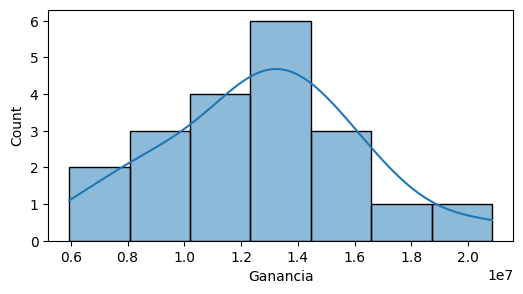

In [39]:
plt.figure(figsize=(6,3))
sns.histplot(df_ganancias["Ganancia"], kde=True)
plt.show()

### Test

In [43]:
# Sobre el mes de abril, debemos usar el modelo que se entreno sobre todos los datos

ganancia_test = ganancia(model, X_futuro, y_futuro)

print(f"Ganancia de modelo en Junio: {ganancia_test}")

# Un poco menos que en el conjunto de entrenamiento, no esta tan mal.

Ganancia de modelo en Junio: 120617000.0


### Simulando Kaggle

In [44]:
# podemos tomar más muestras, dado que solo vamos a scorear y eso es más rápido
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                             test_size=0.3,
                             random_state=semillas[0])

ganancias_futuro_privado = []
ganancias_futuro_publico = []

for train_index, test_index in sss_futuro.split(X_futuro, y_futuro):
  ganancias_futuro_privado.append(ganancia(model, X_futuro.iloc[train_index], y_futuro.iloc[train_index], prop=0.7))
  ganancias_futuro_publico.append(ganancia(model, X_futuro.iloc[test_index], y_futuro.iloc[test_index], prop=0.3))

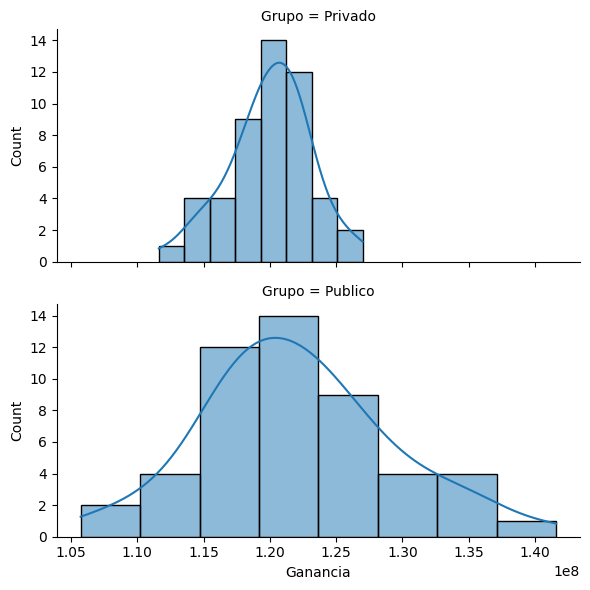

In [45]:
df_pred_publico= pd.DataFrame({'Ganancia': ganancias_futuro_privado, 'Grupo': 'Privado'})
df_pred_privado = pd.DataFrame({'Ganancia': ganancias_futuro_publico, 'Grupo': 'Publico'})

df_combined = pd.concat([df_pred_publico, df_pred_privado])

g = sns.FacetGrid(df_combined, row="Grupo", aspect=2)
g.map(sns.histplot, "Ganancia", kde=True)
plt.show()

In [46]:
mean_privado = df_combined[df_combined['Grupo'] == 'Privado']['Ganancia'].mean()
mean_publico = df_combined[df_combined['Grupo'] == 'Publico']['Ganancia'].mean()

print(f"Ganancia media del modelo en privado: {mean_privado}")
print(f"Ganancia media del modelo en publico: {mean_publico}")

Ganancia media del modelo en privado: 119992400.0
Ganancia media del modelo en publico: 122074400.00000001


### Optimizacion

Para mejorar los modelos, una paso adecuado es la búsqueda de hiperparámetros. Podemos contar con las siguientes técnicas de búsqueda de parámetros:

* **Grid Search**: Explora exhaustivamente todas las combinaciones posibles de hiperparámetros dentro de un conjunto predefinido de valores. Aunque es exhaustivo.

* **Random Search**: En lugar de probar todas las combinaciones posibles, selecciona un número aleatorio de combinaciones de hiperparámetros dentro de un rango predefinido.

* **Bayesian Optimization**: Este método construye un modelo probabilístico del rendimiento de los hiperparámetros y utiliza ese modelo para seleccionar los valores de hiperparámetros más prometedores.

* **Tree-structured Parzen Estimator (TPE)**: Una variante de la optimización bayesiana que utiliza estimadores de densidad basados en árboles (Parzen estimators) para modelar la probabilidad de los hiperparámetros óptimos. Es eficiente en la exploración de espacios de hiperparámetros complejos y se adapta bien a configuraciones con interdependencias entre los parámetros.

* **Genetic Algorithms**: Emplea principios de la evolución natural, como selección, cruce y mutación, para encontrar combinaciones óptimas de hiperparámetros. Es útil en espacios de búsqueda complejos, aunque puede ser computacionalmente costoso.

Para la búsquedas de parámetros usaremos **Optuna**. **Optuna** es una librería poderosa y flexible, diseñada para realizar búsquedas eficientes y automatizadas.

* Utiliza casi todos los álgoritmos mencionados y más.

* Permite definir espacios de búsqueda complejos, incluyendo hiperparámetros categóricos, continuos, discretos y con dependencias condicionales.

* Ofrece un mecanismo de pruning o poda, que permite detener evaluaciones de configuraciones de hiperparámetros que no muestran promesas tempranas.

* Facilidad de Uso y Configuración.

* Proporciona herramientas de visualización integradas para analizar el progreso de la optimización, visualizar la importancia de los hiperparámetros y explorar las configuraciones probadas.

Buscaremos un mejor modelo de manera inteligente:

In [47]:
sss_opt = ShuffleSplit(n_splits=5, test_size=0.3, random_state=semillas[1])

def objective(trial, X, y, sss):
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  max_depth = trial.suggest_int('max_depth', 2, 20)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 200)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 40) # era 20 pero cuando optimize por optuna eligio 20, asique lo cambio para que pruebe con mayores valores

  def train_and_evaluate(train_index, test_index, X, y):
    m = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        random_state=semillas[0],
    )
    m.fit(X.iloc[train_index],y.iloc[train_index])
    ganancia_value = ganancia(m, X.iloc[test_index], y.iloc[test_index], prop=0.3)
    return ganancia_value

  results = Parallel(n_jobs=-1)(
      delayed(train_and_evaluate)(train_index, test_index, X, y)
      for train_index, test_index in sss.split(X)
  )

  return np.mean(results)

Entre la muchas ventajas que tiene **Optuna** es que va almacenando las exploraciones en una base de datos, lo que nos permite continuar la búsqueda si esta se interrumpe.

In [48]:
storage_name = "sqlite:///C:/Eugenio/Maestria/DMEyF/datasets/optimization_tree_e211.db"
study_name = "decision-tree-opt"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-09-21 19:01:45,877] A new study created in RDB with name: decision-tree-opt


In [50]:
study.optimize(lambda trial: objective(trial, X, y, sss_opt), n_trials=100)

[I 2024-09-21 19:03:50,423] Trial 0 finished with value: 86916666.66666667 and parameters: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 180, 'min_samples_leaf': 19, 'max_leaf_nodes': 17}. Best is trial 0 with value: 86916666.66666667.
[I 2024-09-21 19:04:10,431] Trial 1 finished with value: 69449333.33333334 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 132, 'min_samples_leaf': 8, 'max_leaf_nodes': 20}. Best is trial 0 with value: 86916666.66666667.
[I 2024-09-21 19:04:25,401] Trial 2 finished with value: 70359333.33333334 and parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 11, 'max_leaf_nodes': 12}. Best is trial 0 with value: 86916666.66666667.
[I 2024-09-21 19:04:46,496] Trial 3 finished with value: 69449333.33333334 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 133, 'min_samples_leaf': 18, 'max_leaf_nodes': 4}. Best is trial 0 with value: 86916666.6666666

In [51]:
optuna.visualization.plot_optimization_history(study)

In [52]:
plot_param_importances(study)

In [53]:
plot_slice(study)

In [57]:
plot_contour(study)

In [54]:
plot_contour(study, params=["max_depth", "max_leaf_nodes"])

In [55]:
study.best_trial.params

# pareceria que tenemos margen para

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_split': 33,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 20}

Top 10 modelos:

In [65]:
# study.trials[0].value

sorted_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)  # Ascending order for minimization

# Extract the top 10 trials
top_10_trials = sorted_trials[:10]

# Display the parameters for the top 10 trials
for i, trial in enumerate(top_10_trials):
    print(f"Trial {i+1}: Value = {trial.value}, Parameters = {trial.params}")

Trial 1: Value = 92768666.66666667, Parameters = {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 33, 'min_samples_leaf': 2, 'max_leaf_nodes': 20}
Trial 2: Value = 92428000.0, Parameters = {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 35, 'min_samples_leaf': 4, 'max_leaf_nodes': 20}
Trial 3: Value = 92428000.0, Parameters = {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 32, 'min_samples_leaf': 5, 'max_leaf_nodes': 20}
Trial 4: Value = 92428000.0, Parameters = {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 69, 'min_samples_leaf': 3, 'max_leaf_nodes': 20}
Trial 5: Value = 92428000.0, Parameters = {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 59, 'min_samples_leaf': 7, 'max_leaf_nodes': 20}
Trial 6: Value = 92428000.0, Parameters = {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 58, 'min_samples_leaf': 7, 'max_leaf_nodes': 20}
Trial 7: Value = 92428000.0, Parameters = {'criterion': 'entropy', 'ma

In [66]:
study.best_trial.params

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_split': 33,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 20}

In [68]:
# Modelo usando los parametros optimos que encontramos con Optuna:

model = DecisionTreeClassifier(random_state=semillas[2],
                               criterion='entropy',
                               max_depth=6,
                               min_samples_split=33,
                               min_samples_leaf=2,
                               max_leaf_nodes=20)

model.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=20,
                       min_samples_leaf=2, min_samples_split=33,
                       random_state=400391)

In [72]:
# otra forma:

# best_trial = study.best_trial
# best_model_params = best_trial.params
# print("Mejor modelo:", best_model_params)

# model = DecisionTreeClassifier(**best_model_params, random_state=semillas[2])
# model.fit(X, y)

Mejor modelo: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 33, 'min_samples_leaf': 2, 'max_leaf_nodes': 20}


DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=20,
                       min_samples_leaf=2, min_samples_split=33,
                       random_state=400391)

In [69]:
leaf_df = get_leaf_info(model)

leaf_df["ganancia"] = ganancia_acierto*leaf_df["BAJA+2"] - costo_estimulo*leaf_df["BAJA+1"] + -costo_estimulo*leaf_df["CONTINUA"]
leaf_df["prob_baja_2"] = leaf_df["BAJA+2"]/leaf_df["Samples"]

# leaf_df.sort_values("ganancia", ascending=False, inplace=True)
leaf_df.sort_values("prob_baja_2", ascending=False, inplace=True)

leaf_df['gan_acumulada'] = leaf_df['ganancia'].cumsum() # primero tengo que ordenar por prob_baja_2 por eso la pongo aca abajo

leaf_df


,Node,Samples,Predicted Class,BAJA+1,BAJA+2,CONTINUA,ganancia,prob_baja_2,gan_acumulada
3,18,38,CONTINUA,11,8,19,1974000,0.210526,1974000
5,21,579,CONTINUA,69,117,393,28707000,0.202073,30681000
6,22,2708,CONTINUA,254,215,2239,41244000,0.079394,71925000
18,37,1751,CONTINUA,51,92,1608,13503000,0.052541,85428000
2,15,934,CONTINUA,25,45,864,6062000,0.048180,91490000
9,27,3705,CONTINUA,76,111,3518,5145000,0.029960,96635000
1,12,1970,CONTINUA,50,48,1872,-350000,0.024365,96285000
19,38,541,CONTINUA,0,10,531,-987000,0.018484,95298000
16,34,768,CONTINUA,25,13,730,-1736000,0.016927,93562000
8,26,5153,CONTINUA,38,66,5049,-17591000,0.012808,75971000


In [70]:
print(f"Ganancia de modelo Base: {ganancia(model, X, y)}") # lo podes verificar en la tabla de arriba

Ganancia de modelo Base: 96635000.0


In [71]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importances.sort_values('importance', ascending=False).head(20)

,feature,importance
107,ctrx_quarter,0.523374
165,mpayroll_todos,0.124218
166,consumos_mas_DA,0.085667
18,mcaja_ahorro,0.083203
33,mprestamos_personales,0.054319
201,avg3_mcaja_ahorro,0.039145
127,Master_fechaalta,0.016837
133,Visa_status,0.014288
191,avg3_mrentabilidad_annual,0.013574
204,avg3_mcuentas_saldo,0.013149


### Tarea

* Envíos a Kaggle:
 * Defina los mejores parámetros para realizar una búsqueda.
 * Explore la configuración de Optuna para una mejor búsqueda.
 * Arme un script que tome la salida de un modelo y genere un archivo para Kaggle.
 * Entrena el modelo usando datos de febrero y mirando su rendimiento en abril.  
   * Prueba el modelo completo entrenado en febrero, score en Junio y suba a  Kaggle.
   * El modelo seleccionado se reentrena con los datos de abril y se scorea en junio para kaggle
* Busca el mejor modelo en abril y scoree en junio para Kaggle.

¿Cuál fue su mejor predicción?

Colaboración:
* Recuerde compartir con tus compañeros los nuevos scripts que hayas generado y las configuraciones que hayas probado por el canal de

## Random Forest

In [76]:
print(mes_train)
print(mes_test)

202102
202104


In [77]:
X = data[data['foto_mes'] == mes_train]
y = X['clase_ternaria']
X = X.drop(columns=['clase_ternaria'])

X_futuro = data[data['foto_mes'] == mes_test]
y_futuro = X_futuro['clase_ternaria']
X_futuro = X_futuro.drop(columns=['clase_ternaria'])

In [79]:
# variamos la funcion de ganancia para poder usarla de manera mas generica

def ganancia_prob(y_hat, y, prop=1, class_index=1, threshold=0.025):
  @np.vectorize
  def ganancia_row(predicted, actual, threshold=0.025):
    return  (predicted >= threshold) * (ganancia_acierto if actual == "BAJA+2" else -costo_estimulo)

  return ganancia_row(y_hat[:,class_index], y).sum() / prop

In [81]:
# ajustamos el mejor modelo que habiamos obtenido con optuna

best_parameters = {'criterion': 'entropy',
                    'max_depth': 6,
                    'min_samples_split': 33,
                    'min_samples_leaf': 2,
                    'max_leaf_nodes': 20}

model_dt_optuna = DecisionTreeClassifier(random_state=semillas[2], **best_parameters)

model_dt_optuna.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=20,
                       min_samples_leaf=2, min_samples_split=33,
                       random_state=400391)

In [ ]:
y_pred_dt_optuna = model_dt_optuna.predict_proba(X_futuro)

print(f"Ganancia de modelo: {ganancia_prob(y_pred_dt_optuna, y_futuro)}")

Los parámetros que se pueden ajustar en el **rf** son

1. **n_estimators**: Número de árboles en el bosque.
2. **max_depth**: Profundidad máxima de los árboles.
3. **min_samples_split**: Número mínimo de muestras requeridas para dividir un nodo interno.
4. **min_samples_leaf**: Número mínimo de muestras requeridas para estar en un nodo hoja.
5. **max_features**: Número de features a usar en cada árbol. **sqrt** es una elección histórica.
6. **max_leaf_nodes**: Número máximo de nodos hoja en cada árbol.
7. **oob_score**: Indica si se usa la muestra fuera de bolsa (out-of-bag) para estimar la calidad del modelo. Para evitar hacer un **montecarlo-cross-validation** que se toma su tiempo, usaremos esta opción para buscar el mejor modelo. No es la mejor opción. Pero no es tan mala.
8. **n_jobs**: Siempre -1, para que use todos los cores presentes en 9. **max_samples**: Fracción de los samples.

Finalmente nuestra función de optimización queda la siguiente forma:

In [85]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 2000)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 200)
    max_features = trial.suggest_float('max_features', 0.05, 0.7)

    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_samples=0.7,
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True
    )

    model.fit(X, y)

    return ganancia_prob(model.oob_decision_function_, y)

storage_name = "sqlite:///" + db_path + "optimization_forest.db" # mmm no se si hacia falta cambiar el nombre de la base, creo que se puede usar la misma base y lo que hay que cambiar es el nombre del estudio
study_name = "exp_206_random-forest-opt"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)


[I 2024-09-21 20:46:48,785] A new study created in RDB with name: exp_206_random-forest-opt


In [86]:
study.optimize(objective, n_trials=100)

[I 2024-09-21 20:49:23,138] Trial 0 finished with value: 98987000.0 and parameters: {'max_depth': 9, 'min_samples_split': 85, 'min_samples_leaf': 27, 'max_features': 0.3490297402571165}. Best is trial 0 with value: 98987000.0.
[I 2024-09-21 20:56:18,995] Trial 1 finished with value: 94850000.0 and parameters: {'max_depth': 26, 'min_samples_split': 888, 'min_samples_leaf': 71, 'max_features': 0.6338603400919427}. Best is trial 0 with value: 98987000.0.
[I 2024-09-21 21:03:58,897] Trial 2 finished with value: 97790000.0 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 56, 'max_features': 0.6717375095431893}. Best is trial 0 with value: 98987000.0.
[I 2024-09-21 21:05:14,947] Trial 3 finished with value: 98266000.0 and parameters: {'max_depth': 32, 'min_samples_split': 123, 'min_samples_leaf': 153, 'max_features': 0.13875635509093515}. Best is trial 0 with value: 98987000.0.
[I 2024-09-21 21:06:15,570] Trial 4 finished with value: 86037000.0 and parameters: {'

In [87]:
optuna.visualization.plot_optimization_history(study)

In [88]:
plot_param_importances(study)

In [89]:
plot_slice(study)